# Fortune Medical Associates, Predicting Drug Review Results
**By Yamuna Umapathy**

## Business Understanding:

Our Stakeholder Fortune Medical Associates wants us to classify Positive & Negative ratings from given Patient's Drug Review results. We have to
find the best model which predicts patient's review has positive or negative effect after medication. 

## Dataset:

Dataset comes from UCI Machine Learning Respository, https://archive.ics.uci.edu/dataset/462/drug+review+dataset+drugs+com. The dataset provides 
patient reviews on specific drugs along with related conditions and a 10 star patient rating reflecting overall patient satisfaction. The data was obtained by online pharmaceutical review sites.

Dataset was cleaned, and has 215,000 rows and 6 important features to be used for our analysis. Features description as below:

`Unnamed0(ID)`: Patient's File/Medical ID in Medical office (numerical)

`drugName`    : Name of drug prescribed (categorical).

`condition`   : Patient's health condition (categorical).

`review`(text): Patient review after taking drug (categorical).

`rating`      : Patient's review rating after taking medication(float)

`date`        : Date of review entry (date)

`usefulCount` : Number of users who found review useful (numerical)

## Data Exploration & Cleaning:

In [17]:
# Importing all libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
from copy import deepcopy


import nltk
import string
import re
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet # imports WordNet
from nltk import pos_tag
from textblob import TextBlob

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import StackingClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay,RocCurveDisplay,roc_auc_score

import pyLDAvis
import gensim
from gensim.models import Word2Vec
from sklearn.decomposition import NMF 


In [2]:
# Opening our dataset through pandas

df_train = pd.read_csv("data/drugsComTrain_raw.tsv", delimiter='\t', encoding = 'utf-8')
df_train

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37
...,...,...,...,...,...,...,...
161292,191035,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10.0,"May 31, 2015",125
161293,127085,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1.0,"November 1, 2011",34
161294,187382,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2.0,"March 15, 2014",35
161295,47128,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10.0,"September 19, 2015",79


In [3]:
df_test = pd.read_csv("data/drugsComTest_raw.tsv", delimiter='\t', encoding = 'utf-8')
df_test.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,"February 28, 2012",22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,"May 17, 2009",17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,"September 29, 2017",3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,"March 5, 2017",35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,"October 22, 2015",4


In [4]:
# Concatenating our train & test datasets available from source to start EDA

df = pd.concat([df_train, df_test], axis=0, ignore_index=True)
df

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37
...,...,...,...,...,...,...,...
215058,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10.0,"September 13, 2014",43
215059,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9.0,"October 8, 2016",11
215060,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8.0,"November 15, 2010",7
215061,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1.0,"November 28, 2011",20


In [5]:
# renaming column Unnamed: 0 as ID
df = df.rename(columns = {'Unnamed: 0': 'ID'})
df.columns

Index(['ID', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215063 entries, 0 to 215062
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   ID           215063 non-null  int64  
 1   drugName     215063 non-null  object 
 2   condition    213869 non-null  object 
 3   review       215063 non-null  object 
 4   rating       215063 non-null  float64
 5   date         215063 non-null  object 
 6   usefulCount  215063 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 11.5+ MB


In [7]:
# Checking for missingness

df.isna().sum()

ID                0
drugName          0
condition      1194
review            0
rating            0
date              0
usefulCount       0
dtype: int64

Above shows column `condition` has 1194 missing values, since this is Medical field, not using Simple Imputer or other methods to fill in
info which may be risky later. Dropping rows which has missigness for `condition` which is one of the important feature in our analysis.

In [8]:
# dropping Nan's for column condition

df.dropna(subset = ['condition'], inplace=True)
df.isna().sum()

ID             0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

In [9]:
# checking unique values in each column except ID & review 

print(df['drugName'].value_counts(), "\n")
print(df['condition'].value_counts(), "\n")
print(df['rating'].value_counts(), "\n")
print(df['usefulCount'].value_counts())
print(df['review'][0])

drugName
Levonorgestrel                       4896
Etonogestrel                         4402
Ethinyl estradiol / norethindrone    3619
Nexplanon                            2892
Ethinyl estradiol / norgestimate     2682
                                     ... 
Hemin                                   1
Melpaque HP                             1
Cortisone                               1
Reyataz                                 1
Allergy DN PE                           1
Name: count, Length: 3667, dtype: int64 

condition
Birth Control                                   38436
Depression                                      12164
Pain                                             8245
Anxiety                                          7812
Acne                                             7435
                                                ...  
Systemic Candidiasis                                1
Wilson's Disease                                    1
unctional Gastric Disorde                    

## Data Visualization:

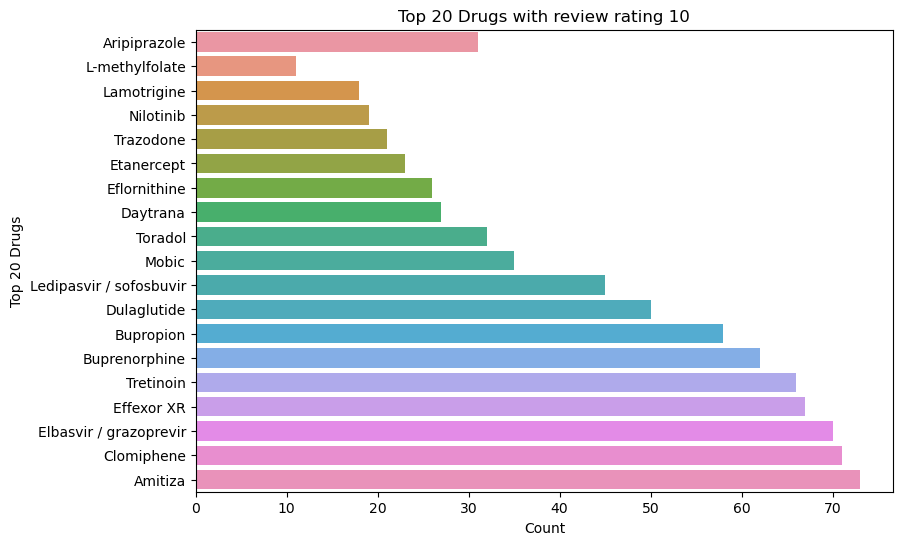

In [46]:
# Visualizing top 20 drugName based on review rating 10

top_20_drugs = df.loc[df['rating']==10,'drugName'].head(20)
plt.figure(figsize = (9,6))
sns.barplot(y=top_20_drugs.values, x=top_20_drugs.index, data=df, errorbar=None)
plt.title("Top 20 Drugs with review rating 10")
plt.ylabel("Top 20 Drugs")
plt.xlabel("Count")
plt.savefig('DataVis1.png', dpi=500)
plt.show()

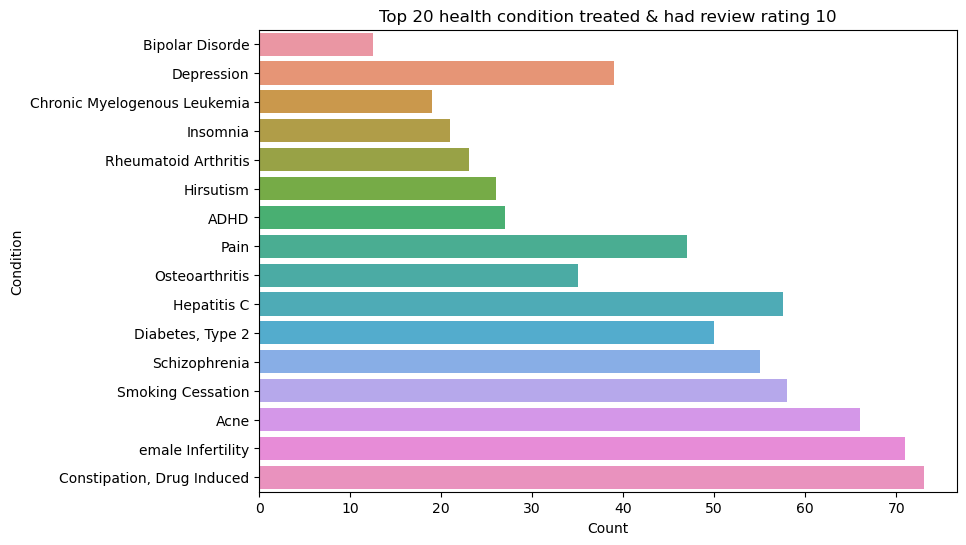

In [82]:
# Visualizing top 20 conditions based on review rating 10

top_20_condition = df.loc[df['rating']==10,'condition'].head(20)
plt.figure(figsize = (9,6))
sns.barplot(y=top_20_condition.values, x=top_20_condition.index, data=df, errorbar=None)
plt.title("Top 20 health condition treated & had review rating 10")
plt.ylabel("Condition")
plt.xlabel("Count")
plt.savefig('Data_vis2.png', dpi=300)
plt.show()

Before starting our preprocessing steps, checking frequency of words. We are choosing column `rating` and splitting into two categories positive 
and negative. Ratings 1-5 falls under negative category, and 6-10 falls under positive category.

In [83]:
# wordtokenize df[review] in corpus
corpus = [word_tokenize(doc) for doc in df['review']]
print(corpus[0])

['``', 'It', 'has', 'no', 'side', 'effect', ',', 'I', 'take', 'it', 'in', 'combination', 'of', 'Bystolic', '5', 'Mg', 'and', 'Fish', 'Oil', "''"]


Let's take a look at tokens after cleaning. Cleaning the list of lists replacing punctuations with blank space, and removing blank space later. Removed numbers from tokens using regex pattern, lowercasing all tokens.

Created two list of lists as positive_corpus(ratings 0-5) & negative_corpus(ratings 6-10), and flattened the list and took unique words to visualize through WordCloud.

In [84]:
# get common stop words in english that we'll remove during tokenization/text normalization
stop_words = stopwords.words('english')

# Cleaning to lowercase, removing punctuation
corpus_norm = [x for x in corpus if ((x not in stop_words))]
translator = str.maketrans('', '', string.punctuation)
corpus_norm1 = [[token.translate(translator) for token in doc] for doc in corpus_norm]
corpus_norm2 = [[token.strip() for token in doc if token.strip()] for doc in corpus_norm1]
corpus_norm3 = [[token.lower() for token in doc] for doc in corpus_norm2]

In [85]:
# Splitting corpus based on ratings, 1-5 as negative, 6-10 as positive

positive_corpus = [doc for doc, rating in zip(corpus_norm3, df['rating']) if rating > 5]
negative_corpus = [doc for doc, rating in zip(corpus_norm3, df['rating']) if rating <= 5]
len(positive_corpus)

149963

In [86]:
# flattening the list of lists to find unique words from positive_corpus
positive_corpus_flat = []
for doc in positive_corpus:
    for word in doc:
        positive_corpus_flat.append(word)

positive_corpus_unique = set(positive_corpus_flat)

# Define a regex pattern to match numbers or words containing numbers
pattern = r'\b(\d+\w+|\w*\d+\w*)\b'

# Apply the regex pattern to filter out unwanted tokens
positive_corpus_filtered = [token for token in positive_corpus_unique if not re.match(pattern, token)]

positive_corpus_filtered[0:10]

['steered',
 'role',
 'sth',
 'thereapist',
 'tendercrampy',
 'sitei',
 'rowing',
 'unneccessary',
 'absentminded',
 'turtlenecks']

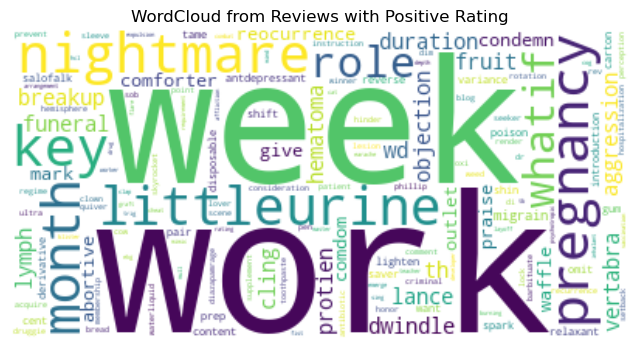

In [91]:
# Create a WordCloud object with default settings
wc = WordCloud(background_color="white")

# Generate the word cloud using your corpus
wc.generate(" ".join(positive_corpus_filtered))

# Display the word cloud
plt.figure(figsize=(8,6))
plt.imshow(wc, interpolation="bilinear")
plt.title("WordCloud from Reviews with Positive Rating")
plt.axis("off")
plt.savefig('Pos_WordCl.png', dpi=300)
plt.show()

In [89]:
# flattening list of lists, and create unique tokens from negative_corpus

negative_corpus_flat = []
for doc in negative_corpus:
    for word in doc:
        negative_corpus_flat.append(word)

negative_corpus_unique = set(negative_corpus_flat)

# Define a regex pattern to match numbers or words containing numbers
pattern = r'\b(\d+\w+|\w*\d+\w*)\b'

# Apply the regex pattern to filter out unwanted tokens
negative_corpus_filtered = [token for token in negative_corpus_unique if not re.match(pattern, token)]

negative_corpus_filtered[0:10]

['cuckoos',
 'steered',
 'role',
 'rowing',
 'baddd',
 'dubai',
 'entities',
 'timenothing',
 'sodiumblockers',
 'unmanageable']

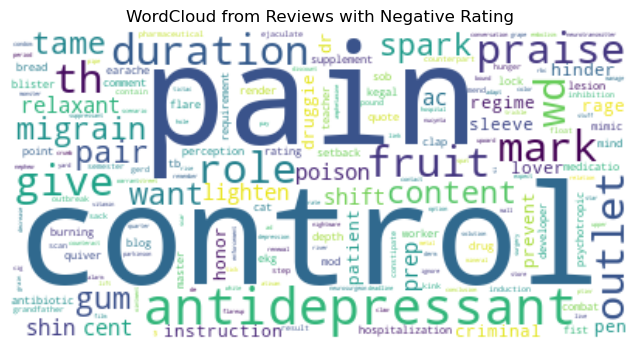

In [92]:
# Create a WordCloud object with default settings
wc = WordCloud(background_color="white")

# Generate the word cloud using your corpus
wc.generate(" ".join(negative_corpus_filtered))

# Display the word cloud
plt.figure(figsize=(8,6))
plt.imshow(wc, interpolation="bilinear")
plt.title("WordCloud from Reviews with Negative Rating")
plt.axis("off")
plt.savefig('Neg_WordCl.png', dpi=300)
plt.show()

## Preprocessing:

**Target Variable `rating`**

Implementing TextPreprocessor calling class function, following cleaning process will be completed: Lowercasing, Tokenizing and removing
stopwords, Tagging POS and Lemmatizing. 

In [10]:
# class function for preprocessing
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, data, y = 0):
        return self

    def transform(self, data, y = 0):
        normalized_corpus = data.apply(self.process_doc)
        return normalized_corpus

    def process_doc(self, doc):
        lemm = WordNetLemmatizer()
        stop_words = stopwords.words('english')
        def pos_tagger(nltk_tag):
            if nltk_tag.startswith('J'):
                return wordnet.ADJ
            elif nltk_tag.startswith('V'):
                return wordnet.VERB
            elif nltk_tag.startswith('N'):
                return wordnet.NOUN
            elif nltk_tag.startswith('R'):
                return wordnet.ADV
            else:         
                return None
        normalized_doc = [token.lower() for token in word_tokenize(doc) if ((token.isalpha()) & (token not in stop_words))]
        tagged_tokens = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(normalized_doc)))
        normalized_doc = [lemm.lemmatize(token, pos) for token, pos in tagged_tokens if pos is not None]
        return " ".join(normalized_doc)
     

In [11]:
# Making a copy before Train Test Split data
df_med = df.copy()
df_med.head()

,ID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [12]:
# Classifying Target variable as 2 classes: positive_rating (6-10) & negative_rating(0-5)
df_med['rating'] = df_med['rating'].replace({1.0:0, 2.0:0, 3.0:0, 4.0:0, 5.0:0, 6.0:1, 7.0:1, 8.0:1, 9.0:1, 10.0:1})
df_med['rating'].value_counts()

rating
1.0    149963
0.0     63906
Name: count, dtype: int64

Target variable has class imbalance, positive rating 70% and negative rating 30%. Using down sampling method, and have class 0 and class 1 with
same size 50K.

In [13]:
# Downsampling method
pos_df = df_med[df_med['rating']==1]
neg_df = df_med[df_med['rating']==0]

sample_size = 50000
ds_pos_df = pos_df.sample(n=sample_size, random_state=42)
ds_neg_df = neg_df.sample(n=sample_size, random_state=42)


In [14]:
# merging 2 datasets
balanced_df = pd.concat([ds_pos_df, ds_neg_df])
balanced_df['rating'].value_counts()

rating
1.0    50000
0.0    50000
Name: count, dtype: int64

In [15]:
# Lowercasing columns drugName, condition
balanced_df['drugName'] = balanced_df['drugName'].str.lower()
balanced_df['condition'] = balanced_df['condition'].str.lower()
balanced_df['condition'].value_counts()

condition
birth control                   20104
depression                       5496
pain                             3538
anxiety                          3365
acne                             3292
                                ...  
oppositional defiant disorde        1
zollinger-ellison syndrome          1
gaucher disease                     1
acute promyelocytic leukemia        1
varicose veins                      1
Name: count, Length: 802, dtype: int64

In [21]:
balanced_df['review'][0:1]

26630    "My last medication Velafaxine stopped working...
Name: review, dtype: object

## Baseline Model with Random Forest Classifier:

In [22]:
# Train test split

X = balanced_df['review']
y= balanced_df['rating']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((70000,), (30000,), (70000,), (30000,))

In [23]:
# preprocessing
lemm = TextPreprocessor()
X_train_trans = lemm.fit_transform(X_train)
X_test_trans = lemm.transform(X_test)

In [24]:
# creating pipeline
model1_pipe = Pipeline([('countvec', CountVectorizer(min_df=0.05, max_df=0.95)),
                   ('model',RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42))
                    ])

# initiating model
model1_pipe.fit(X_train_trans, y_train)

Pipeline(steps=[('countvec', CountVectorizer(max_df=0.95, min_df=0.05)),
                ('model',
                 RandomForestClassifier(max_depth=3, random_state=42))])

In [25]:
# predicting on X_test
y_pred_model1 = model1_pipe.predict(X_test_trans)
print("Accuracy:", accuracy_score(y_pred_model1, y_test))
print("F1 Score:", f1_score(y_pred_model1, y_test))
print("Precision:", precision_score(y_pred_model1, y_test))
print("Recall:", recall_score(y_pred_model1, y_test))
print(classification_report(y_pred_model1, y_test))
      

Accuracy: 0.6551666666666667
F1 Score: 0.6500930153898191
Precision: 0.6406666666666667
Recall: 0.6598008925506351
              precision    recall  f1-score   support

         0.0       0.67      0.65      0.66     15435
         1.0       0.64      0.66      0.65     14565

    accuracy                           0.66     30000
   macro avg       0.66      0.66      0.66     30000
weighted avg       0.66      0.66      0.66     30000



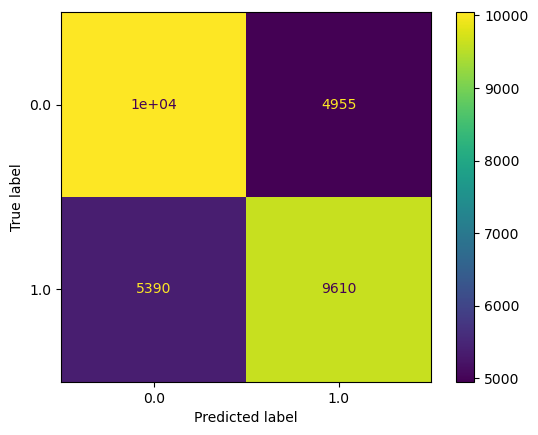

In [333]:
ConfusionMatrixDisplay.from_estimator(model1_pipe, X_test_trans, y_test);

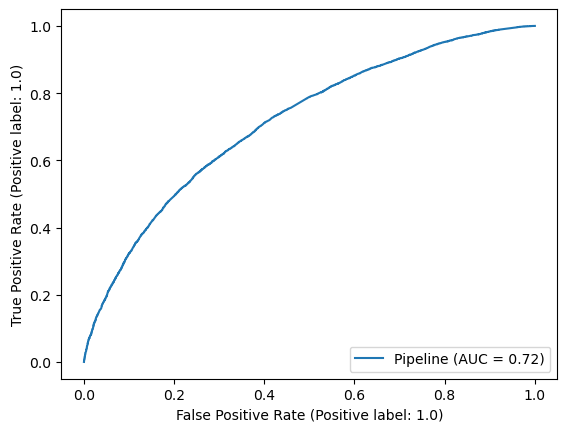

In [340]:
# ROC curve
RocCurveDisplay.from_estimator(model1_pipe, X_test_trans, y_test);

In [334]:
#Get the feature names from the vectorized X
feature_names = model1_pipe['countvec'].get_feature_names_out()

# retrieving transformed X_train and X_test
X_train_trans_df = model1_pipe.named_steps['countvec'].transform(X_train_trans)
X_test_trans_df = model1_pipe.named_steps['countvec'].transform(X_test_trans)

X_train_df = pd.DataFrame(X_train_trans_df.toarray(),columns=feature_names)
X_train_df

,acne,ago,almost,also,always,anxiety,away,back,bad,be,...,think,time,try,use,want,week,weight,well,work,year
0,0,0,1,0,0,0,0,0,0,0,...,1,2,0,0,0,3,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,1,3,0
69996,0,0,0,2,0,0,0,0,1,0,...,0,0,0,0,0,1,1,0,0,1
69997,0,0,1,0,0,0,0,4,1,0,...,1,0,1,0,0,0,2,0,0,4
69998,0,0,0,0,0,1,1,0,0,0,...,0,0,0,1,0,1,0,0,0,4


In [335]:
y_train_df = pd.DataFrame(y_train.reset_index(drop=True), columns=['rating'])
train_df = pd.concat([X_train_df, y_train_df], axis=1)
train_df

,acne,ago,almost,also,always,anxiety,away,back,bad,be,...,time,try,use,want,week,weight,well,work,year,rating
0,0,0,1,0,0,0,0,0,0,0,...,2,0,0,0,3,0,1,0,0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0.0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,1,3,0,1.0
69996,0,0,0,2,0,0,0,0,1,0,...,0,0,0,0,1,1,0,0,1,0.0
69997,0,0,1,0,0,0,0,4,1,0,...,0,1,0,0,0,2,0,0,4,0.0
69998,0,0,0,0,0,1,1,0,0,0,...,0,0,1,0,1,0,0,0,4,0.0


In [336]:
pos_med_tokens = train_df[train_df['rating'] == 1].sum(axis=0).sort_values(ascending=False)
neg_med_tokens = train_df[train_df['rating'] == 0].sum(axis=0).sort_values(ascending=False)
print("Positive Tokens: \n", pos_med_tokens, "\n Negative tokens:\n", neg_med_tokens)


Positive Tokens: 
 rating      35000.0
take        29444.0
day         21081.0
get         18047.0
year        16221.0
             ...   
next         1712.0
stomach      1673.0
swing        1443.0
horrible     1397.0
not          1223.0
Length: 119, dtype: float64 
 Negative tokens:
 take       28677.0
get        20978.0
day        20723.0
month      16967.0
go         15166.0
            ...   
ago         1841.0
far         1562.0
many        1558.0
finally     1471.0
rating         0.0
Length: 119, dtype: float64


Baseline Model scored accuracy 66, and f1 score 65. We are using Accuracy as Metrics since dataset is balanced one. 

## RandomizedSearchCV with Hyperparameter Tuning:
**Random Forest Classifier**

To improve and get better results for our model, trying Hyperparameter Tuning through Randomized Search CV option. 

In [38]:
# parameter grid
params_rf = {'model__n_estimators': [10, 50, 100] ,
             'model__min_samples_leaf': [1,3,5],
            'model__max_depth': [3, 5, None]}



In [40]:
# initiating model
model2_pipe = Pipeline([('countvec', CountVectorizer(min_df=0.05, max_df=0.95)),
                      ('model', RandomForestClassifier(random_state=42))])
                    
# create randomizedsearch object for rf
random_search1 = RandomizedSearchCV(model2_pipe, params_rf, cv=5, scoring = 'accuracy', n_iter=10)

#Fit gridsearch to data
random_search1.fit(X_train_trans, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('countvec',
                                              CountVectorizer(max_df=0.95,
                                                              min_df=0.05)),
                                             ('model',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'model__max_depth': [3, 5, None],
                                        'model__min_samples_leaf': [1, 3, 5],
                                        'model__n_estimators': [10, 50, 100]},
                   scoring='accuracy')

In [41]:
random_search1.best_params_

{'model__n_estimators': 100,
 'model__min_samples_leaf': 1,
 'model__max_depth': None}

In [42]:
random_search1.best_score_

0.7639857142857143

In [44]:
# fitting with our best model
rf_bestmodel = random_search1.best_estimator_
rf_bestmodel.fit(X_train_trans, y_train)


Pipeline(steps=[('countvec', CountVectorizer(max_df=0.95, min_df=0.05)),
                ('model', RandomForestClassifier(random_state=42))])

In [32]:
# Accuracy & classification report
y_pred_rf_rscv = rf_bestmodel.predict(X_test_trans)
print("Accuracy for Randomized Search with model RandomForest:", accuracy_score(y_test, y_pred_rf_rscv))
print("F1 Score for Randomized Search with model RandomForest:", f1_score(y_test, y_pred_rf_rscv))
print("Precision for Randomized Search with model RandomForest:", precision_score(y_test, y_pred_rf_rscv))
print("Recall for Randomized Search with model RandomForest:", recall_score(y_test, y_pred_rf_rscv))
print(classification_report(y_test, y_pred_rf_rscv))
      

Accuracy for Randomized Search with model RandomForest: 0.7627333333333334
F1 Score for Randomized Search with model RandomForest: 0.760948414830736
Precision for Randomized Search with model RandomForest: 0.7667162966973471
Recall for Randomized Search with model RandomForest: 0.7552666666666666
              precision    recall  f1-score   support

         0.0       0.76      0.77      0.76     15000
         1.0       0.77      0.76      0.76     15000

    accuracy                           0.76     30000
   macro avg       0.76      0.76      0.76     30000
weighted avg       0.76      0.76      0.76     30000



Random Forest with tuned hyper parameters {'model__n_estimators': 100,  'model__min_samples_leaf': 3 
 'model__max_depth': Non e}scored better accuracy score 76 than our Baseline model. Checking XGBoost Classifier next for better models.

**XGBoost Classifier**

In [33]:
# defining parameter grid
params_xg = {'model__n_estimators': [10, 50, 100],  
             'model__max_depth': [3, 5, None],  
             'model__min_child_weight': [2,3,5], 
             'model__learning_rate': [0.1, 0.2, 0.3] 
             }

model3_pipe = Pipeline([('countvec', CountVectorizer(min_df=0.05, max_df=0.95)),
                        ('model', XGBClassifier(random_state=42))
                       ])


In [34]:
# create randomizedsearch object for xgboost
random_search2 = RandomizedSearchCV(model3_pipe, params_xg, cv=5, scoring = 'accuracy', n_iter=12)

#Fit randomozedsearch to data
random_search2.fit(X_train_trans, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('countvec',
                                              CountVectorizer(max_df=0.95,
                                                              min_df=0.05)),
                                             ('model',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feature_types=None,
                                                            gamma=None,
                                                            g...
                                                            max_leaves=None,
                                                            min_child_weight=None,
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            random_state=42, ...))]),
                   n_iter=12,
                   param_distributions={'model__learning_rate': [0.1, 0.2, 0.3],
                                        'model__max_depth': [3, 5, None],
                                        'model__min_child_weight': [2, 3, 5],
                                        'model__n_estimators': [10, 50, 100]},
                   scoring='accuracy')

In [35]:
random_search2.best_params_

{'model__n_estimators': 100,
 'model__min_child_weight': 2,
 'model__max_depth': 5,
 'model__learning_rate': 0.3}

In [36]:
random_search2.best_score_

0.7100142857142856

In [37]:
# Accuracy & classification report
xg_estimator = random_search2.best_estimator_
y_pred_xg_rscv = xg_estimator.predict(X_test_trans)
print("Accuracy for Randomized Search with model XGBoost:", accuracy_score(y_test, y_pred_xg_rscv))
print("F1 score for Randomized Search with model XGBoost:", f1_score(y_test, y_pred_xg_rscv))
print("Precision for Randomized Search with model XGBoost:", precision_score(y_test, y_pred_xg_rscv))
print("Recall for Randomized Search with model XGBoost:", recall_score(y_test, y_pred_xg_rscv))
print(classification_report(y_test, y_pred_xg_rscv))

Accuracy for Randomized Search with model XGBoost: 0.7083666666666667
F1 score for Randomized Search with model XGBoost: 0.7055893932765758
Precision for Randomized Search with model XGBoost: 0.7123734456750697
Recall for Randomized Search with model XGBoost: 0.6989333333333333
              precision    recall  f1-score   support

         0.0       0.70      0.72      0.71     15000
         1.0       0.71      0.70      0.71     15000

    accuracy                           0.71     30000
   macro avg       0.71      0.71      0.71     30000
weighted avg       0.71      0.71      0.71     30000



XGBoost with tuned hyper parameters scored accuracy score of 71, not good than our previous model score 76.

## Stacking:

Stacking is a learning technique that combines all Base models predictions, and meta-model takes the predictions from the base models as input features and learns how to weigh or combine them effectively.

In [18]:
balanced_df.head()

,ID,drugName,condition,review,rating,date,usefulCount
26630,225117,bupropion,bipolar disorde,"""My last medication Velafaxine stopped working...",1.0,"March 1, 2016",23
78003,131930,effexor xr,hot flashes,"""I had hot flashes every 2 hours. My face woul...",1.0,"April 1, 2012",157
93462,43061,phenytoin,seizures,"""This medication was prescribed to me as a 37 ...",1.0,"October 13, 2009",9
191644,189176,oxycodone,chronic pain,"""This drug works great""",1.0,"February 4, 2017",4
213309,206437,mesalamine,"ulcerative colitis, active","""I have found that it works great for my flare...",1.0,"July 19, 2009",8


Linear Support Vector Classifier as first model, works often faster and more efficient when dealing with large datasets. Linear SVC is suitable for high-dimensional and sparse data, which is often the case with text data. 

Using Naive Bayes as second model, which is probabilistic classifier that assumes independence between features (words) given the class. It is known for its simplicity and efficiency and can work well with text data (Input). Naive Bayes classifiers are based on the Bayes' theorem and make predictions by calculating the probability of a class given the observed features. They can handle high-dimensional data efficiently, making them suitable for text classification tasks.

Finally, using Logistic Regression as third model, another popular choice for binary classification with text data. It models the relationship between the features and the log-odds of the target class, allows to estimate the probability of the target class.

In [19]:
# Train test split
X = balanced_df['review']
y= balanced_df['rating']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X,y, test_size=0.3, stratify=y, random_state=42)
X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape

((70000,), (30000,), (70000,), (30000,))

In [24]:
# preprocessing II
stop_words = stopwords.words('english') 
class StemPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, data, y = 0):
        return self

    def transform(self, data, y = 0):
        normalized_corpus = data.apply(self.stem_doc)
        return normalized_corpus
       
    def stem_doc(self, doc):
        stemmer = SnowballStemmer('english')
        lower_doc = [token.lower() for token in word_tokenize(doc) if token.isalpha()]
        filtered_doc = [token for token in lower_doc if token not in stop_words]
        stemmed_doc = [stemmer.stem(token) for token in filtered_doc]
        return " ".join(stemmed_doc)

In [25]:
# Stemming
stemm = StemPreprocessor()
X_train2_trans_stemm = stemm.fit_transform(X_train2)
X_test2_trans_stemm = stemm.transform(X_test2)

In [26]:
# stacking base models
estimators = [
    ('lrsvc', LinearSVC(C=10, class_weight='balanced', dual=True,max_iter=1000)),
    ('mnb', MultinomialNB(alpha = 0.1)),
    ('logreg', LogisticRegression(max_iter=1000))
]

# initiating meta model
sr = StackingClassifier(estimators)

In [28]:
#creating pipeline
stack_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                        ('model', sr)])

# fitting meta model
stack_pipe.fit(X_train2_trans_stemm, y_train2)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('model',
                 StackingClassifier(estimators=[('lrsvc',
                                                 LinearSVC(C=10,
                                                           class_weight='balanced',
                                                           dual=True)),
                                                ('mnb',
                                                 MultinomialNB(alpha=0.1)),
                                                ('logreg',
                                                 LogisticRegression(max_iter=1000))]))])

In [30]:
# checking score
stack_pipe.score(X_test2_trans_stemm, y_test2)

0.8031666666666667

In [32]:
# checking accuracy score, dataset is balanced
y_pred_st = stack_pipe.predict(X_test2_trans_stemm)
print("Accuracy score for stacking model:", accuracy_score(y_pred_st, y_test2))
print("Classification Report:", classification_report(y_pred_st, y_test2))

Accuracy score for stacking model: 0.8031666666666667
Classification Report:               precision    recall  f1-score   support

         0.0       0.81      0.80      0.80     15111
         1.0       0.80      0.81      0.80     14889

    accuracy                           0.80     30000
   macro avg       0.80      0.80      0.80     30000
weighted avg       0.80      0.80      0.80     30000



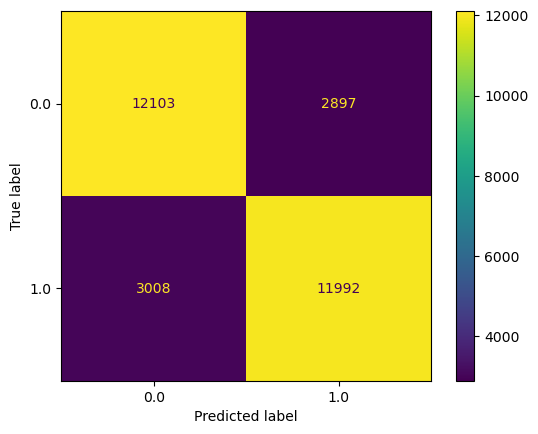

In [33]:
ConfusionMatrixDisplay.from_estimator(stack_pipe, X_test2_trans_stemm, y_test2);
plt.savefig("confusionmatrix_stmodel.png", dpi=300)

In [34]:
print("F1 score for stacking model:", f1_score(y_pred_st, y_test2))
print("Precision score for stacking model:", precision_score(y_pred_st, y_test2))
print("Recall score for stacking model:", recall_score(y_pred_st, y_test2))

F1 score for stacking model: 0.8024356786777744
Precision score for stacking model: 0.7994666666666667
Recall score for stacking model: 0.8054268251729465


Stacking model outperformed all models and scored best accuracy score 80.3. 

False Positive: Negative Reviews which was assigned under Positive reviews, means these patient's reviews has to be taken into serious consideration to                 follow up for appointment to diagnose why the medication failed to work.

False Negative: Positive reviews assigned under Negative reviews, means these patients can have quick follow up that they are doing well after                          medication, and can set up an appointment if health condition repeats.

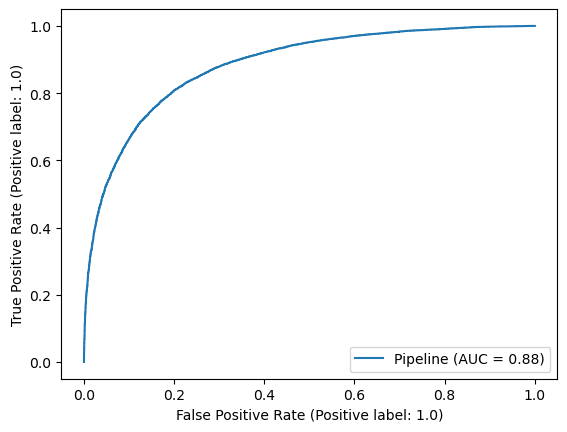

In [35]:
# ROC curve
RocCurveDisplay.from_estimator(stack_pipe, X_test2_trans_stemm, y_test2);

In [36]:
# Assuming you have a trained StackingClassifier named 'stack_pipe'
stack_clf = stack_pipe['model']  # Access the StackingClassifier model from the pipeline


In [44]:
# Get feature names
feature_names = stack_pipe['tfidf'].get_feature_names_out()

# Access the base models
svc_model = stack_clf.named_estimators_['lrsvc']
logreg_model = stack_clf.named_estimators_['logreg']

# Get the coefficients
coefficients = svc_model.coef_[0]

# Sort the coefficients in descending order
sorted_indices = np.argsort(svc_feature_importance)[::-1]
# Define the number of top features to display
top_n = 15
top_feature_names = [feature_names[index] for index in sorted_indices[:top_n]]
top_coefficients = [coefficients[index] for index in sorted_indices[:top_n]]
print(f"{top_feature_names}:{top_coefficients}")

['ahccc', 'divers', 'aftershock', 'valid', 'psyllium', 'oesphagus', 'encro', 'chalki', 'pockmark', 'broomstick', 'uncoat', 'scroll', 'lifesav', 'gabriella', 'scapegoat']:[-6.760696901702702, -6.414291760671304, -6.399823551493027, -6.387092043187862, -6.2880619254147, 6.245215000866, 6.213677207299366, 6.2051191647320225, -6.173918084147369, 6.022251195177147, -6.01886978350715, 6.014804445454532, 5.970356975840502, -5.966364636538787, -5.949247566256377]


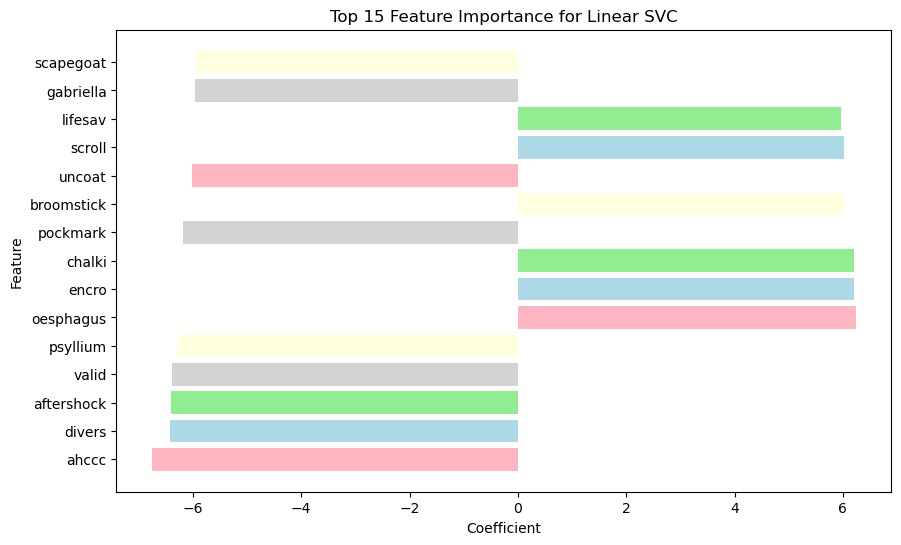

In [40]:
# Visualizing top 15 feature importance in Linear SVC 

plt.figure(figsize=(10, 6))
color_palette = ['lightpink', 'lightblue', 'lightgreen', 'lightgray', 'lightyellow']
plt.barh(top_feature_names, top_coefficients, color = color_palette)
plt.ylabel('Feature')
plt.xlabel('Coefficient')
plt.title('Top 15 Feature Importance for Linear SVC')
plt.show()

In [45]:
# Get the coefficients
coefficients1 = logreg_model.coef_[0]

# Print feature importance for LogisticRegression
logreg_feature_importance = abs(logreg_model.coef_[0])


# Sort the coefficients in descending order
sorted_indices1 = np.argsort(logreg_feature_importance)[::-1]

# Define the number of top features to display
top_n = 15
top_feature_names1 = [feature_names[index] for index in sorted_indices1[:top_n]]
top_coefficients1 = [coefficients1[index] for index in sorted_indices1[:top_n]]
print(f"{top_feature_names1}:{top_coefficients1}")

['miracl', 'love', 'best', 'amaz', 'worst', 'wors', 'great', 'disappoint', 'life', 'wonder', 'saver', 'awesom', 'ruin', 'horribl', 'excel']:[7.838121798268221, 7.13093468404144, 6.786435486694474, 6.489909689301981, -6.029150123845978, -5.900295332945417, 5.741112923836133, -5.460943945508823, 5.438750923909848, 5.2566919950905175, 5.117167603551467, 4.6289692294546825, -4.5875940585019945, -4.5355684330852375, 4.522406303704147]


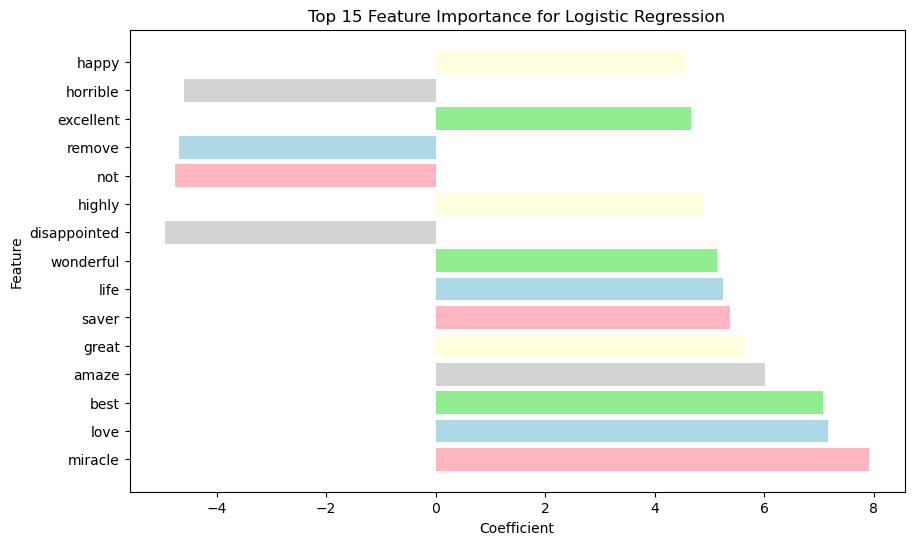

In [97]:
# Visualizing top 15 feature importance

plt.figure(figsize=(10, 6))
color_palette = ['lightpink', 'lightblue', 'lightgreen', 'lightgray', 'lightyellow']
plt.barh(top_feature_names1, top_coefficients1, color = color_palette)
plt.ylabel('Feature')
plt.xlabel('Coefficient')
plt.title('Top 15 Feature Importance for Logistic Regression')
plt.savefig("Top15Feature_Stmodel.png", dpi=300)
plt.show()

Visualizing feature importance from Base models LinearSVC & Logistic Regression. Above graph shows Words such as happy, excellent, highly,
wonderful, life, great... looks like positive rating words. Words such as horrible, not, remove, disappointed...looks like negative rating 
words. .


## Topic Modeling:

Topic modeling is a statistical modeling technique used to identify latent topics or themes within a collection of documents. It is an unsupervised learning method that aims to discover the underlying patterns and structure in a text corpus.

Non-Negative Matrix Factorization (NMF) is an alternative technique for topic modeling, which is based on linear algebra and matrix factorization. NMF is often used for dimensionality reduction and feature extraction tasks. The algorithm factorizes the document-term matrix into the document-topic matrix and the topic-term matrix. The number of topics to extract needs to be specified beforehand.

$ X = WH $
- $ W $ encodes the importance of each token in the fitted topics. 
- $ H $ encodes the weight of the fitted topics for each document. 

In [15]:
balanced_df.head()

,ID,drugName,condition,review,rating,date,usefulCount
26630,225117,Bupropion,Bipolar Disorde,"""My last medication Velafaxine stopped working...",1.0,"March 1, 2016",23
78003,131930,Effexor XR,Hot Flashes,"""I had hot flashes every 2 hours. My face woul...",1.0,"April 1, 2012",157
93462,43061,Phenytoin,Seizures,"""This medication was prescribed to me as a 37 ...",1.0,"October 13, 2009",9
191644,189176,Oxycodone,Chronic Pain,"""This drug works great""",1.0,"February 4, 2017",4
213309,206437,Mesalamine,"Ulcerative Colitis, Active","""I have found that it works great for my flare...",1.0,"July 19, 2009",8


In [16]:
df_med2 = deepcopy(balanced_df).drop(columns = ['rating'])
df_med2.head()

,ID,drugName,condition,review,date,usefulCount
26630,225117,Bupropion,Bipolar Disorde,"""My last medication Velafaxine stopped working...","March 1, 2016",23
78003,131930,Effexor XR,Hot Flashes,"""I had hot flashes every 2 hours. My face woul...","April 1, 2012",157
93462,43061,Phenytoin,Seizures,"""This medication was prescribed to me as a 37 ...","October 13, 2009",9
191644,189176,Oxycodone,Chronic Pain,"""This drug works great""","February 4, 2017",4
213309,206437,Mesalamine,"Ulcerative Colitis, Active","""I have found that it works great for my flare...","July 19, 2009",8


In [17]:
df_med2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 26630 to 167687
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ID           100000 non-null  int64 
 1   drugName     100000 non-null  object
 2   condition    100000 non-null  object
 3   review       100000 non-null  object
 4   date         100000 non-null  object
 5   usefulCount  100000 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 5.3+ MB


In [20]:
df_med2['review'][10:11]

72923    "My son was aggressive and was doing poorly in...
Name: review, dtype: object

Preprocess `review` data for removing stopwords, using regex to remove numbers and special signs and lemmatize.

In [21]:
# additional argument sets cut off minimum length for tokenized text at which function converts to null string.
def process_tweet(tweet_text, min_length):
    
    # get common stop words that we'll remove during tokenization/text normalization
    stop_words = stopwords.words('english')

    #initialize lemmatizer
    wnl = WordNetLemmatizer()

    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
   

    # lower case everything
    tweet_lower = tweet_text.lower()

    #remove mentions, hashtags, and urls, strip whitspace and breaks
    tweet_lower = re.sub(r"@[a-z0-9_]+|#[a-z0-9_]+|http\S+", "", tweet_lower).strip().replace("\r", "").replace("\n", "").replace("\t", "")
    
    
    # remove stop words and punctuations 
    tweet_norm = [x for x in word_tokenize(tweet_lower) if ((x.isalpha()) & (x not in stop_words)) ]

    #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize
    
    # creates list of tuples with tokens and POS tags in wordnet format
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(tweet_norm))) 

    # now we are going to have a cutoff here. any tokenized cocument with length < min length will be removed from corpus
    if len(wordnet_tagged) <= min_length:
        return ''
    else:
         # rejoins lemmatized sentence 
         tweet_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in wordnet_tagged if x[1] is not None])
         return tweet_norm



In [22]:
# applying function to preprocess review column
df_med2['review'] = df_med2['review'].apply(process_tweet, args = [10])

In [23]:
# some documents are short enough cleaning may have wiped it out.
df_med2_new = df_med2[df_med2['review'] != '']

In [24]:
df_med2_new['review']

26630     last medication velafaxine stop work thank mon...
78003     hot flash hour face turn beet red glass fog al...
93462     medication prescribe year old cancer patient d...
213309    find work great flare ups retain night difficu...
12863     trinessa year work fine discontinue use form b...
                                ...                        
8042      give sarafem help moodiness rage week month ta...
965       put mg week titrate everything cool wk start f...
108729    implanon inserted month everything go great mo...
61838     take pill month want contraceptive pill contro...
167687    birth control little year originally start per...
Name: review, Length: 91198, dtype: object

In [25]:
# Apply tf-idf vectorizer to transform the preprocessed text into a term-document matrix.
corpus = df_med2_new['review']
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(corpus)
X_train

<91198x33470 sparse matrix of type '<class 'numpy.float64'>'
	with 3105022 stored elements in Compressed Sparse Row format>

In [27]:
#Number of unique tokens in our term frequency matrix
len(vectorizer.get_feature_names_out())

33470

In [30]:
# using NMF topic modeling
topic_model = NMF(n_components = 2)
topic_model.fit(X_train)


NMF(n_components=2)

Our model has fitted W and H, so we can get these components independently.
- $ W $ encodes the importance of each token in the fitted topics. 
- $ H $ encodes the weight of the fitted topics for each document. 

In [31]:
# to get H
H = topic_model.transform(X_train) # transform document into topic vector representation

# to get W 
W = topic_model.components_ # word component weights for each topic

print("Shape of H is " + str(H.shape))
print("Shape of W is " + str(W.shape))
print("Shape of X_train is " + str(X_train.shape))

Shape of H is (91198, 2)
Shape of W is (2, 33470)
Shape of X_train is (91198, 33470)


In [32]:
# weight for given token
print(W[0])
print(len(W[0]))

[0.00511278 0.00025244 0.00012977 ... 0.00028137 0.00015596 0.00030322]
33470


In [34]:
for index,topic in enumerate(W):
    print(f'THE TOP 25 WORDS FOR TOPIC #{index}')
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-50:]])
    print('\n')

THE TOP 25 WORDS FOR TOPIC #0
['nausea', 'experience', 'say', 'headache', 'prescribe', 'even', 'severe', 'think', 'really', 'stop', 'also', 'depression', 'mg', 'much', 'still', 'dose', 'good', 'life', 'give', 'quot', 'first', 'drug', 'felt', 'use', 'back', 'try', 'hour', 'make', 'bad', 'doctor', 'night', 'well', 'get', 'anxiety', 'medicine', 'week', 'year', 'sleep', 'help', 'time', 'start', 'medication', 'side', 'go', 'effect', 'feel', 'work', 'pain', 'day', 'take']


THE TOP 25 WORDS FOR TOPIC #1
['horrible', 'ever', 'thing', 'breast', 'remove', 'almost', 'nexplanon', 'make', 'recommend', 'lose', 'really', 'skin', 'use', 'pound', 'take', 'love', 'shot', 'switch', 'also', 'drive', 'last', 'experience', 'pregnant', 'stop', 'light', 'time', 'heavy', 'never', 'day', 'go', 'bad', 'swing', 'year', 'spot', 'start', 'mood', 'sex', 'first', 'week', 'acne', 'cramp', 'weight', 'bleed', 'gain', 'birth', 'control', 'get', 'pill', 'month', 'period']




In [38]:
%%capture topic_word_plot
def plot_top_words(W, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 2, figsize=(10,8), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(W):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20
tfidf_feature_names = vectorizer.get_feature_names_out()
plot_top_words(W, tfidf_feature_names, n_top_words, "Topics in NMF model")

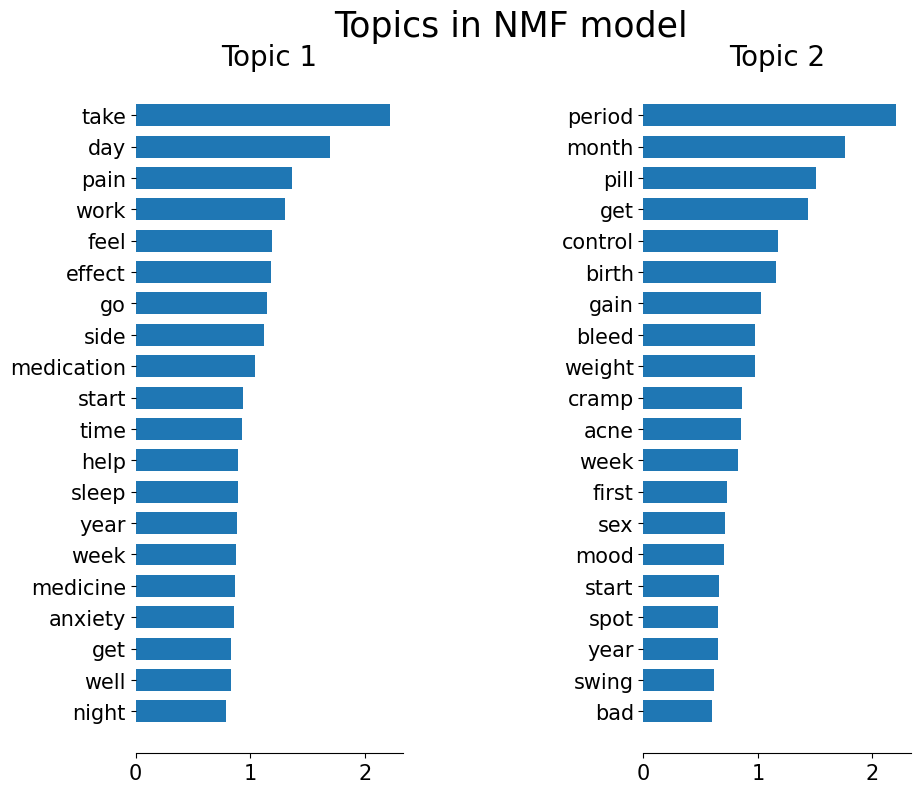

In [39]:
topic_word_plot()

In [40]:
# Retrieve the vocabulary and term frequency
vocab = vectorizer.get_feature_names_out()
term_frequency = X_train.toarray()  # Convert sparse matrix to array
term_frequency1 = np.asarray(X_train.sum(axis=0)).ravel()

print("Vocabulary: ", vocab, len(vocab))
print("Term Frequency: ", term_frequency1, len(term_frequency1))

Vocabulary:  ['aa' 'aaa' 'aaaaaammazing' ... 'zzzquill' 'zzzzap' 'zzzzzzzz'] 33470
Term Frequency:  [11.4867229   0.9739033   0.24239563 ...  0.39877039  0.24422962
  0.75769993] 33470


In [43]:
doc_lengths = [len(" ".join(str(term) for term in document).split()) for document in X_train]

In [49]:
normalized_doc_topic_dists = H / np.sum(H, axis=1, keepdims=True)

In [54]:
vis = pyLDAvis.prepare(topic_term_dists=W, doc_topic_dists=normalized_doc_topic_dists, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency1)
pyLDAvis.display(vis)

C:\Users\uyamu\anaconda3\envs\tf_env\lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\uyamu\anaconda3\envs\tf_env\lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\uyamu\anaconda3\envs\tf_env\lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [51]:
pyLDAvis.save_html(vis, 'nmf_topics.html')

## Conclusion:

Based on model evaluation, Stacking Model using base models (Linear SVC, Naive Bayes & Logistic Regression) performed the best accuracy score 80.3 compared to others. We are focussing on metrics Accuracy since our dataset is balanced, and sample was taken from the main dataset. Baseline Random Forest scored accuracy of 66, Randomized Search CV for XGBoost scored accuracy 72, and Randomized SearchCV for Random Forest scored accuracy 76. Also we checked TensorFlow model, which scored accuracy 78.8. 

Based on Confusion matrix and Classification report, we can focus on both True Negative and False Positive, means patient's Drug effect was Negative, and this has to be addressed through patient follow-up.

We also looked into Topic Modeling, this was very helpful to distinguish between Posive and Negative ratings clearly. Topic Modeling helped us to visualize both topics Positive Rating & Negative rating through pyLDAvis Visualization. 

## Next Steps:

For Phase 2, we can look into using Word2Vec algorithm,  widely used word representation technique. This type of word representation or Word Embeddings 
can be used to infer semantic similarity between words and phrases, expand queries, surface related concepts and more.
